# Diabetes Classification

## ``Step 1: Define the Problem``
Develop an algorithm to predict the diabetic nature of a patient based on the certain diagnostic measurement.
## ``Step 2: Gather the Data``
### Description of Dataset
This dataset is originally from the `National Institute of Diabetes and Digestive and Kidney Diseases`. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

In [1]:
%load_ext autoreload
%autoreload 2

## ``STEP 3: Prepare Data``
### ``3.1: Import Libraries``

In [2]:
import pandas as pd
import os
import dotenv
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys
import warnings
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

from lazypredict.Supervised import LazyClassifier

from sklearn.metrics import recall_score, classification_report, make_scorer
import optuna
import pickle

warnings.filterwarnings("ignore")
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
plt.rcParams['figure.figsize'] = 5,5

In [3]:
dotenv.load_dotenv()
sys.path.append('../src')

from load_data import DataIngestorFactory

### ``3.2: Meet and Greet Data``

#### Content
The datasets consists of several medical predictor variables and one target variable, Outcome.

Predictor variables includes:
1. `Pregnancies`: The number of pregnancies the patient has had. It is descrete quantitative datatype.
2. `Plasma Glucose`: Commonly known as blood sugar measured in mg/dl (milligram/deciliter) Note: 1 deciliter = 100 milliliter. It is continuous quantitative datatype.
3. `Diastolic Blood Pressure`:The bottom number in a blood pressure reading, which measures the force of blood in your arteries when your heart is relaxed between beats.
4. `Triceps Thickness`:A measurement of subcutaneous fat(fat that is stored under your skin and can be pinched.) in the limbs and is used to estimate total body fat composition. It is continuous quantitative datatype.
5. `Serum Insuline`: A measurement of the amount of insulin in a person's blood. Continuous quantitative datatype.
6. `BMI`: Body Mass Indes is quantitative datatype.
7. `Diabetes Pedigree`:A family tree that shows the diabetes status of each family member, as well as other relevant information. A diabetes pedigree can be used to calculate the likelihood of a person developing diabetes based on their family history and age. This calculation is called the Diabetes Pedigree Function (DPF), and it produces a score that ranges from 0.08 to 2.42. A higher DPF score indicates a higher likelihood of developing diabetes. This is continuous datatype.
8. `Age`: Age of the patient. This is continuous quantitative datatype.
9. `Diabetic`: It is a binary nominal descrete datatype with values 0 and 1.

In [4]:
data_ingestor = DataIngestorFactory().get_data_ingestor(file_extension="db")
table_name = "diabetes"
if data_ingestor:
    df: pd.DataFrame = data_ingestor.ingest(
        db_name=os.getenv("MYSQL_DATABASE"),
        table_name=table_name,
        db_password=os.getenv("MYSQL_PASSWORD"),
        db_host="localhost",
    )

2024-12-27 13:13:02.029 | INFO     | load_data:connect_database:44 - Database connected successfully.


In [5]:
print("-*-"*30)
print("FIRST 5 ROWS")
print("-*-"*30)
print(df.head())
print("-*-"*30)
print("LAST 5 ROWS")
print("-*-"*30)
print(df.tail())
print("-*-"*30)
print("RANDOM 5 ROWS")
print("-*-"*30)
print(df.sample(5))

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
FIRST 5 ROWS
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
   PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
0    1354778            0            171                      80   
1    1147438            8             92                      93   
2    1640031            7            115                      47   
3    1883350            9            103                      78   
4    1424119            1             85                      59   

   TricepsThickness  SerumInsulin   BMI  DiabetesPedigree  Age  Diabetic  
0                34            23 43.51              1.21   21         0  
1                47            36 21.24              0.16   23         0  
2                52            35 41.51              0.08   23         0  
3                25           304 29.58              1.28   43         1  
4                27  

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               10000 non-null  int64  
 1   Pregnancies             10000 non-null  int64  
 2   PlasmaGlucose           10000 non-null  int64  
 3   DiastolicBloodPressure  10000 non-null  int64  
 4   TricepsThickness        10000 non-null  int64  
 5   SerumInsulin            10000 non-null  int64  
 6   BMI                     10000 non-null  float64
 7   DiabetesPedigree        10000 non-null  float64
 8   Age                     10000 non-null  int64  
 9   Diabetic                10000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 781.4 KB


### ✤ Insights From Data Types
1. There are 7 columns with data type as integer
2. There are 2 columns with float64 datatype.

>Note: There are no categorical features

In [7]:
df.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,1502122.08,3.26,107.85,71.21,28.82,139.24,31.57,0.40,30.13,0.33
std,289286.76,3.41,31.92,16.80,14.51,133.78,9.80,0.38,12.11,0.47
min,1000038.00,0.00,44.00,24.00,7.00,14.00,18.20,0.08,21.00,0.00
25%,1251672.25,0.00,84.00,58.00,15.00,39.00,21.25,0.14,22.00,0.00
50%,1504394.00,2.00,105.00,72.00,31.00,85.00,31.92,0.20,24.00,0.00
75%,1754607.50,6.00,129.00,85.00,41.00,197.00,39.33,0.62,35.00,1.00
max,1999997.00,14.00,192.00,117.00,92.00,796.00,56.03,2.30,77.00,1.00


### ✤ Insights From Summary Statistics
1. `PlasmaGlucose` ranges from **44** to **192** indicating data with low blood glucose as well as high blood glucose. Depends on how data was collected i.e. During Fasting or After Eating or 2-3 Hours after eating, the range varies.
2. `DiastolicBloodPressure` has range from **24 mm Hg** to **117 mm Hg** indicating people with extremely high blood pressure as well as extremely low blood pressure.
3. `SerumInsulin` has outliers which might affect the prediction. It's minimum value is 14 which indicates, these women might be suffering from diabetes.
4. `BMI`: The maximum BMI is 56 which indicates some women fall into `obese` category.
5. `DiabetesPedigree` whose value range from 0.08 to 2.42, majority of values lie below _**0.62**_ indicating there are only 25% of observation higher than 0.62. Also the mean of 0.4 indicates that women on average has less chance of getting a diabetes.

The target variable `Diabetic` has a mean of 0.334 which means there is **33.4%** chance of getting diabetes.

In [8]:
df.isna().sum(axis=0)

PatientID                 0
Pregnancies               0
PlasmaGlucose             0
DiastolicBloodPressure    0
TricepsThickness          0
SerumInsulin              0
BMI                       0
DiabetesPedigree          0
Age                       0
Diabetic                  0
dtype: int64

#### Missing Values Analysis (Completing)
This dataset has no missing values.
#### Correcting
1. **Dropping of column**<br>
Column `PatientID` is non usable and does not contribute to the target varaible. Thus dropping it.
2. **Outlier detection and handeling**<br>
Column `SerumInsulin` has outlier which need to be handled.
#### Creating
1. We may want to create a new feature for Age bands. This converts continuous into descrete ordinal feature.
2. We want to create a range for Pregnancies, PlasmaGlucose, DiastolicBloodPressure, SerumInsulin, BMI, DiabetesPedigree.

### ✤ Issues to be addressed later
3. **Correlation and Multicollinearity**<br>
Multiple independent columns might be correlated with eachother. Performing test and removing such correlation will help in doing effective prediction.

#### Dropping unwanted columns

In [9]:
df.drop(columns=["PatientID"], inplace=True)

### Analyzing by visualizing
#### Correlating numerical features

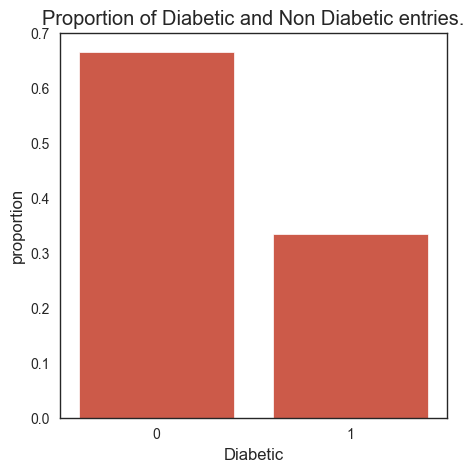

In [10]:
sns.countplot(data=df, x="Diabetic", stat="proportion")
plt.title("Proportion of Diabetic and Non Diabetic entries.")
plt.ylim([0.0,0.7]);

More than **65%** of women in the data are non diabetic and about **30%** are diabetic. Showing class imbalance. <br>

**Decision** <br>
- Implement SMOTE or any other over sampling algorithm to solve the class imbalance problem.

#### * Age

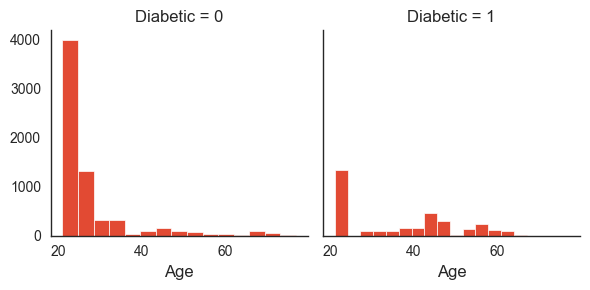

In [11]:
g = sns.FacetGrid(data=df, col="Diabetic")
g.map(plt.hist, 'Age',bins=15)

#### Insights
1. Women with Age > 60 did not suffer from diabetes.
2. Most of womens with Age >20 and Age < 50 have higher diabetes rate.
3. Most womens are in the range of 20-50 years.

**Decision** <br>
- Consider Age for model training.

#### * Number of Pregnancies

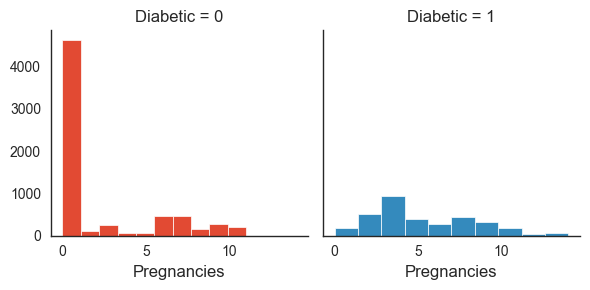

In [12]:
g = sns.FacetGrid(data=df, col="Diabetic", hue="Diabetic")
g.map(plt.hist, "Pregnancies")

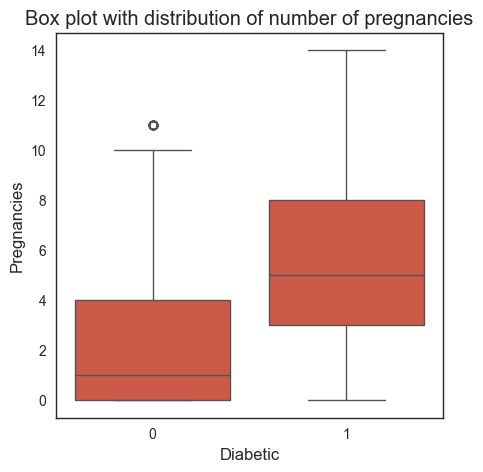

In [13]:
sns.boxplot(data=df, x="Diabetic", y="Pregnancies")
plt.title("Box plot with distribution of number of pregnancies");

#### Insights
1. Apparently women with 3 to 4 children are more prone to diabetes.
2. Women with no children are more less prone to diabetes.

**Decision** <br>
- Condider Pregnancies for model training.

#### * Plasma Glucose

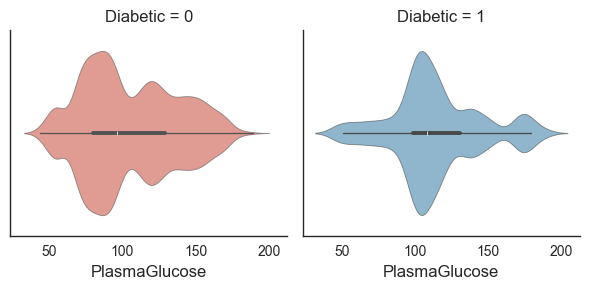

In [14]:
g = sns.FacetGrid(data=df, col="Diabetic", hue="Diabetic")
g.map(sns.violinplot, "PlasmaGlucose", alpha=0.6)

### Insights
1. Majority of diabetic women have glucose level around 100.
1. Majority of non-diabetic women have glucose level around 80.

#### * DiastolicBloodPressure

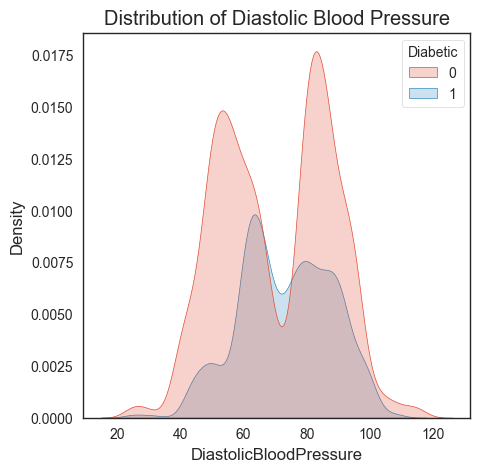

In [15]:
sns.kdeplot(data=df, x="DiastolicBloodPressure", hue="Diabetic", shade=True)
plt.title("Distribution of Diastolic Blood Pressure");

#### Insights
1. Women with Diastolic Blood Pressure around 50 and 80 have lesser chance of getting diabetes.

#### * TricepsThickness

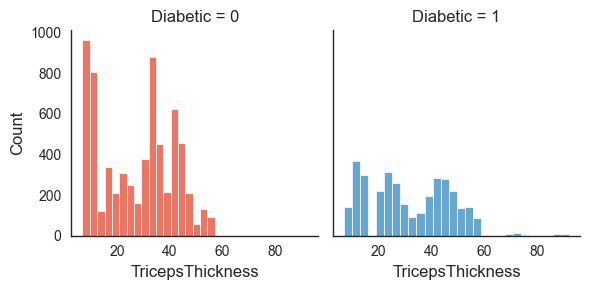

In [16]:
g = sns.FacetGrid(data=df, col="Diabetic", hue="Diabetic")
g.map(sns.histplot, "TricepsThickness");

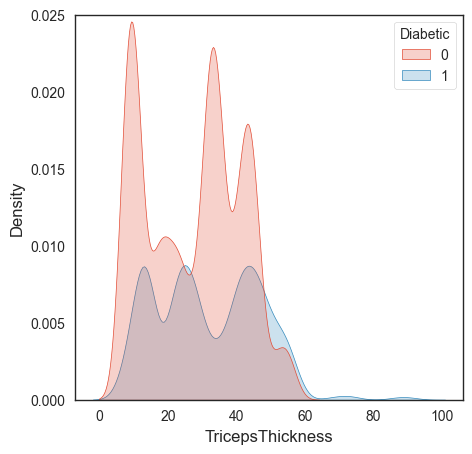

In [17]:
sns.kdeplot(data=df, x="TricepsThickness", hue="Diabetic", shade=True)
plt.ylim([0, 0.025]);

#### *Serum Insulin

<Axes: xlabel='SerumInsulin', ylabel='Density'>

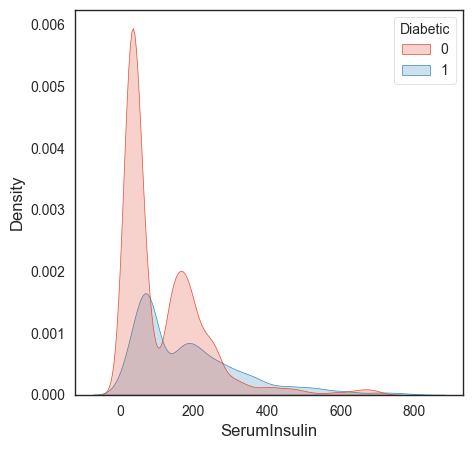

In [18]:
sns.kdeplot(data=df, x="SerumInsulin", hue="Diabetic", shade=True)

#### Insights
1. There is no difference in distribution of Insulin level in their blood with respect to Diabetic and Non-Diabetic women.

**Decision**<br>
- Do not Include SerumInsulin in model training.

<Axes: xlabel='BMI', ylabel='Density'>

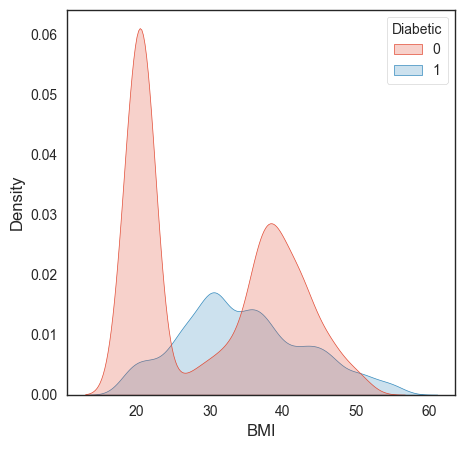

In [19]:
sns.kdeplot(data=df, x="BMI", hue="Diabetic", shade=True)

#### Insights
1. For Non-Diabetic women majority of BMI is around 20 and 40. 20 makes sense as it is healthy level but 40 is extremely obese.
2. Suprisingly women with BMI 30 are most prone to diabetes.

**Decision** <br>
- Include BMI in model training.

#### * DiabetesPedigree

<Axes: xlabel='DiabetesPedigree', ylabel='Density'>

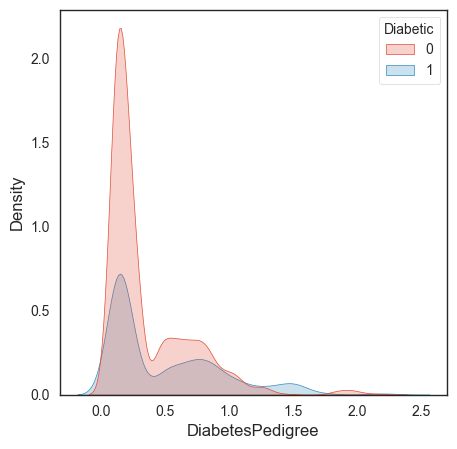

In [20]:
sns.kdeplot(data=df, x="DiabetesPedigree", hue="Diabetic", shade=True)

#### Insights
1. Again the distribution of Diabetic women looks like scaled down version of Non-Diabetic women.
2. This distribution is not showing any pattern which could be helpful distinguishing between two classes

**Decision**
- Do not include it in model training.

#### Correlation Analysis

<Axes: >

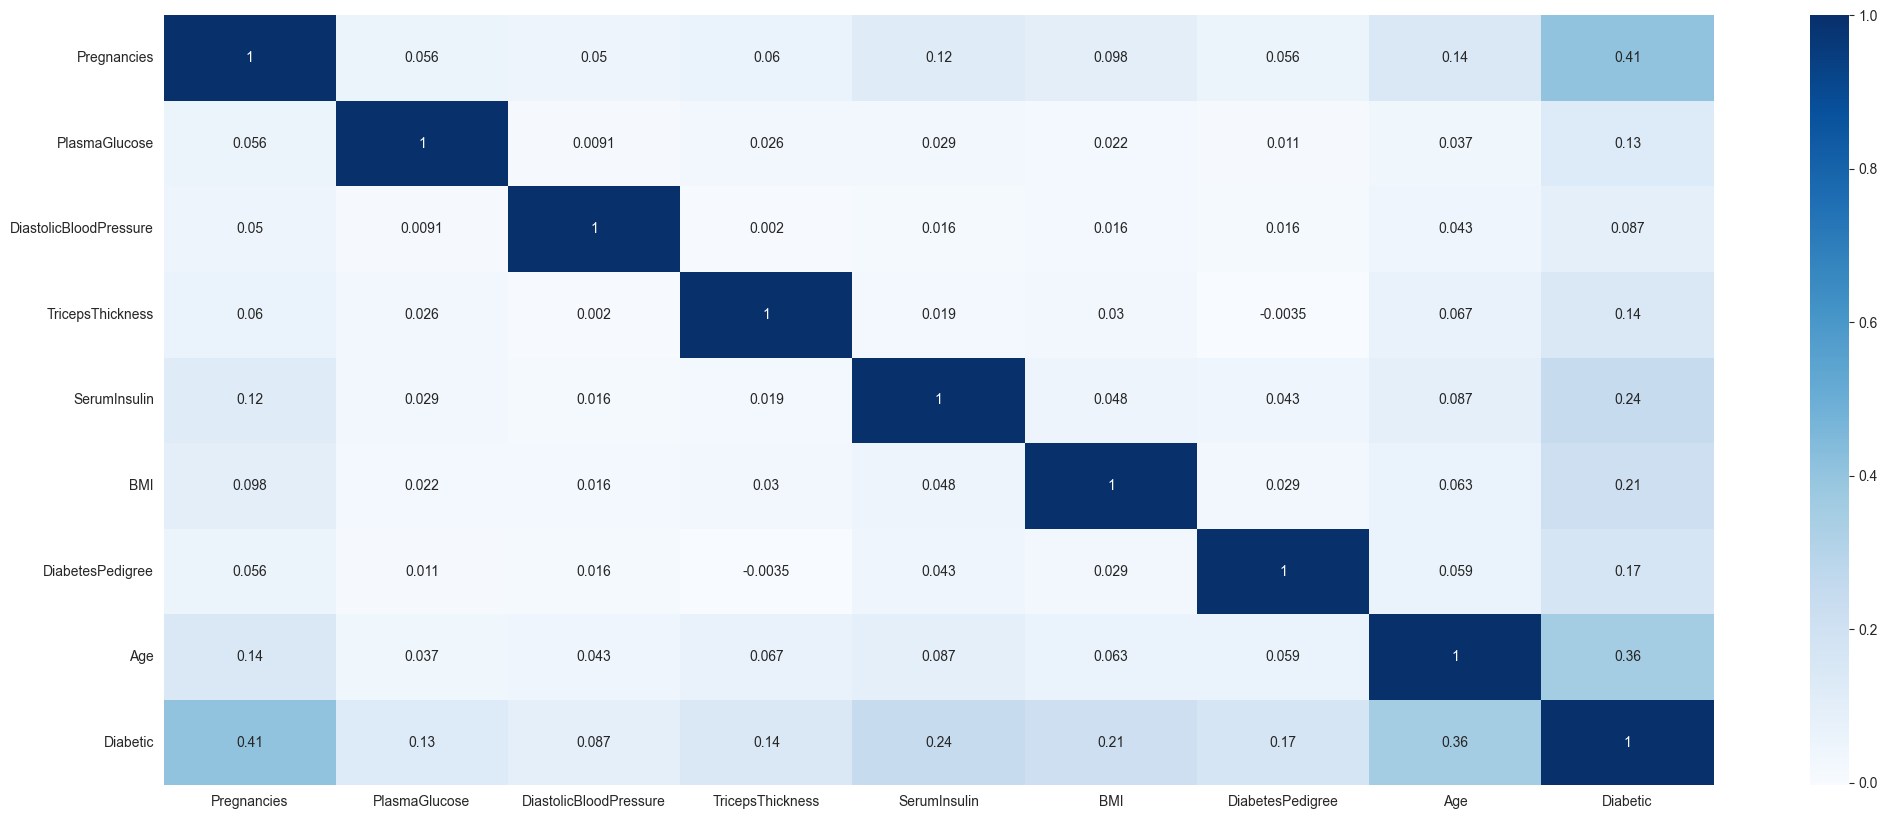

In [21]:
plt.figure(figsize=(25,10))
sns.heatmap(df.corr(),annot=True, cmap="Blues")

## ``4. Model Building``
### Base Model Using LazyPredict

In [22]:
X = df.drop(columns=["Diabetic"],axis=1)
y = df["Diabetic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=12345)

# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     random_state=12345,
                     custom_metric=recall_score)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

 97%|█████████▋| 31/32 [00:24<00:00,  1.66it/s]

[LightGBM] [Info] Number of positive: 2675, number of negative: 5325
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1136
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334375 -> initscore=-0.688463
[LightGBM] [Info] Start training from score -0.688463


100%|██████████| 32/32 [00:25<00:00,  1.28it/s]


In [39]:
models.sort_values(by="recall_score", ascending=[False])

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,recall_score,Time Taken
Model,,,,,,
LGBMClassifier,0.96,0.96,0.96,0.96,0.94,0.46
AdaBoostClassifier,0.95,0.94,0.94,0.95,0.93,0.93
RandomForestClassifier,0.95,0.94,0.94,0.95,0.91,2.38
ExtraTreesClassifier,0.94,0.93,0.93,0.94,0.91,1.40
BaggingClassifier,0.94,0.93,0.93,0.94,0.90,0.78
DecisionTreeClassifier,0.90,0.89,0.89,0.90,0.86,0.14
SVC,0.89,0.88,0.88,0.89,0.83,3.26
KNeighborsClassifier,0.88,0.86,0.86,0.88,0.81,0.47
LabelSpreading,0.85,0.83,0.83,0.85,0.78,4.88


#### Decision
1. Using Logistic Regression with 0.63 recall score, lightweight, and fast.
2. Using LightGBM for its high recall score.
3. Using Decision Tree for balanced approach.

### Logistic Regression(Fast) LGBM Classifier(High Recall) and Decision Tree (Balanced)

In [25]:
from pathlib import Path
from sklearn.metrics import confusion_matrix
from loguru import logger

In [26]:
model_save_dir: Path = Path(".").resolve().parents[0] / "saved" / "model"
report_save_dir: Path = Path(".").resolve().parents[0] / "saved" / "report"
logger.info(f"Model save directory: {model_save_dir}")
logger.info(f"Report save directory: {report_save_dir}")

2024-12-27 13:13:41.764 | INFO     | __main__:<module>:3 - Model save directory: C:\Work\Python\FastAPI\Week-2\Classification\saved\model
2024-12-27 13:13:41.765 | INFO     | __main__:<module>:4 - Report save directory: C:\Work\Python\FastAPI\Week-2\Classification\saved\report


In [27]:
def compute_recall(model_object, model_name):
    predict_labels = model_object.predict(X_test)
    score = recall_score(np.rint(predict_labels), y_test)
    logger.info(f"Recall Score for {model_name}: {round(score, 3)}")

def save_model(model_object, file_name):
    file_name = file_name + ".pkl"
    with open(model_save_dir / file_name, mode="wb") as file:
        pickle.dump(model_object, file)
    logger.info(f"Model saved successfully in {model_save_dir/file_name}")

def save_report(model_object, file_name):
    file_name = file_name + ".png"
    predict_labels = model_object.predict(X_test)
    sns.heatmap(confusion_matrix(np.rint(predict_labels), y_test), 
                annot=True, fmt="g")
    plt.savefig(report_save_dir / file_name,
                bbox_inches="tight",
                dpi=300)
    logger.info(f"Confusion matrix for successfully saved in: {report_save_dir/file_name}")

2024-12-27 13:13:42.265 | INFO     | __main__:compute_recall:4 - Recall Score for Logistic Regression: 0.628
2024-12-27 13:13:42.280 | INFO     | __main__:save_model:10 - Model saved successfully in C:\Work\Python\FastAPI\Week-2\Classification\saved\model\logistic_regression.pkl
2024-12-27 13:13:42.765 | INFO     | __main__:save_report:20 - Confusion matrix for successfully saved in: C:\Work\Python\FastAPI\Week-2\Classification\saved\report\confusion_matrix_logistic_regression.png


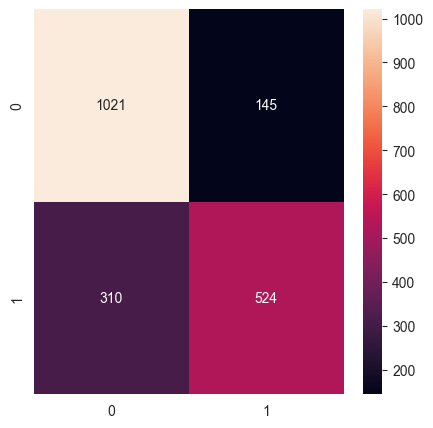

In [28]:
logistic_model = LogisticRegression(penalty="l2",
                                    solver="sag",
                                    class_weight="balanced",
                                    max_iter=100,
                                    random_state=12345)
logistic_model.fit(X_train, y_train)
compute_recall(logistic_model, "Logistic Regression")
save_model(logistic_model, "logistic_regression")
save_report(logistic_model,"confusion_matrix_logistic_regression")

In [29]:
def objective(trial):
    criterion = trial.suggest_categorical("criterion", ["gini","entropy","log_loss"])
    max_depth = trial.suggest_int("max_depth", 5,50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_sample_leaf = trial.suggest_int("min_sample_leaf", 2, 10)
    classifier_obj = DecisionTreeClassifier(criterion=criterion,
                                            max_depth=max_depth,
                                            min_samples_split=min_samples_split,
                                            min_samples_leaf=min_sample_leaf,
                                            class_weight="balanced",
                                            random_state=12345)
    
    score = cross_val_score(classifier_obj,
                            X_train,
                            y_train,
                            n_jobs=-1,
                            scoring=make_scorer(recall_score),
                            cv=10)
    mean_recall = score.mean()
    return mean_recall
    

In [30]:
study = optuna.create_study(direction="maximize", study_name="Decision Tree")
study.optimize(objective, n_trials=100)
logger.info(study.best_trial)
logger.info(f"Best parameters for Decision Tree Classifier: {study.best_params}")

[I 2024-12-27 13:13:43,365] A new study created in memory with name: Decision Tree
[I 2024-12-27 13:13:50,661] Trial 0 finished with value: 0.8713958298395662 and parameters: {'criterion': 'log_loss', 'max_depth': 13, 'min_samples_split': 8, 'min_sample_leaf': 3}. Best is trial 0 with value: 0.8713958298395662.
[I 2024-12-27 13:13:53,977] Trial 1 finished with value: 0.8945762759237521 and parameters: {'criterion': 'entropy', 'max_depth': 44, 'min_samples_split': 7, 'min_sample_leaf': 9}. Best is trial 1 with value: 0.8945762759237521.
[I 2024-12-27 13:13:54,227] Trial 2 finished with value: 0.8650511487506287 and parameters: {'criterion': 'log_loss', 'max_depth': 30, 'min_samples_split': 8, 'min_sample_leaf': 3}. Best is trial 1 with value: 0.8945762759237521.
[I 2024-12-27 13:13:54,415] Trial 3 finished with value: 0.8945706858963609 and parameters: {'criterion': 'gini', 'max_depth': 11, 'min_samples_split': 10, 'min_sample_leaf': 9}. Best is trial 1 with value: 0.8945762759237521.
[

2024-12-27 13:16:30.935 | INFO     | __main__:compute_recall:4 - Recall Score for Decision Tree: 0.87
2024-12-27 13:16:30.941 | INFO     | __main__:save_model:10 - Model saved successfully in C:\Work\Python\FastAPI\Week-2\Classification\saved\model\decision_tree.pkl
2024-12-27 13:16:31.457 | INFO     | __main__:save_report:20 - Confusion matrix for successfully saved in: C:\Work\Python\FastAPI\Week-2\Classification\saved\report\confusion_matrix_decision_tree.png


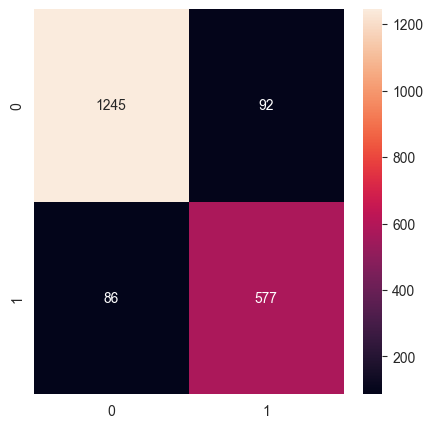

In [36]:
decision_tree_model = DecisionTreeClassifier(criterion= 'log_loss',
                                             max_depth= 6,
                                             min_samples_split= 9,
                                             min_samples_leaf= 2)
decision_tree_model.fit(X_train, y_train)


compute_recall(decision_tree_model, "Decision Tree")
save_model(decision_tree_model, "decision_tree")
save_report(decision_tree_model,"confusion_matrix_decision_tree")

In [37]:
feature_importances = pd.DataFrame(decision_tree_model.feature_importances_,
                                   index = df.columns[:-1])

print(feature_importances)

                          0
Pregnancies            0.52
PlasmaGlucose          0.03
DiastolicBloodPressure 0.00
TricepsThickness       0.00
SerumInsulin           0.08
BMI                    0.18
DiabetesPedigree       0.01
Age                    0.17


In [33]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    dtrain = lgb.Dataset(X_train, label=y_train)
    gbm = lgb.train(param, dtrain) 
    y_hat = gbm.predict(X_test)
    recall = recall_score(np.rint(y_hat), y_test)
    return recall

In [34]:
study = optuna.create_study(direction="maximize", study_name="LightGBM")
study.optimize(objective, n_trials=100)
logger.info(study.best_trial)
logger.info(study.best_params)

[I 2024-12-27 13:14:20,010] A new study created in memory with name: LightGBM
[I 2024-12-27 13:14:20,591] Trial 0 finished with value: 0.9236417033773862 and parameters: {'lambda_l1': 0.0017501332526758731, 'lambda_l2': 9.333171808826869e-06, 'num_leaves': 69, 'feature_fraction': 0.9880087300468802, 'bagging_fraction': 0.979535761338317, 'bagging_freq': 1, 'min_child_samples': 48}. Best is trial 0 with value: 0.9236417033773862.
[I 2024-12-27 13:14:21,330] Trial 1 finished with value: 0.9315476190476191 and parameters: {'lambda_l1': 1.2109337004179478e-07, 'lambda_l2': 2.9726598373655277e-08, 'num_leaves': 249, 'feature_fraction': 0.8941326738417794, 'bagging_fraction': 0.7990834891780874, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 1 with value: 0.9315476190476191.
[I 2024-12-27 13:14:21,665] Trial 2 finished with value: 0.9389880952380952 and parameters: {'lambda_l1': 0.0006108296595236679, 'lambda_l2': 1.7887301829084038e-08, 'num_leaves': 161, 'feature_fraction': 0.6

2024-12-27 13:18:01.905 | INFO     | __main__:compute_recall:4 - Recall Score for LightGBM: 0.945
2024-12-27 13:18:01.920 | INFO     | __main__:save_model:10 - Model saved successfully in C:\Work\Python\FastAPI\Week-2\Classification\saved\model\lgb.pkl
2024-12-27 13:18:02.484 | INFO     | __main__:save_report:20 - Confusion matrix for successfully saved in: C:\Work\Python\FastAPI\Week-2\Classification\saved\report\confusion_matrix_lgb.png


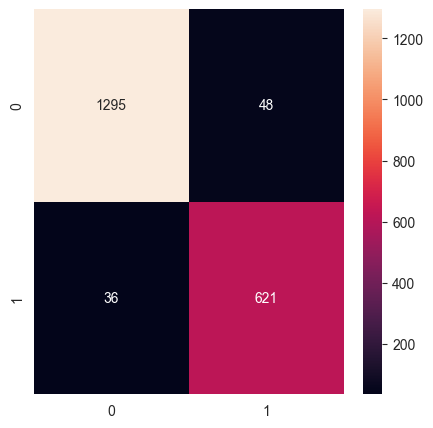

In [38]:
best_params = {'lambda_l1': 0.24315703675009112,
               'lambda_l2': 0.00023906894735921676,
               'num_leaves': 241,
               'feature_fraction': 0.7906673741843152,
               'bagging_fraction': 0.4532512541258397,
               'bagging_freq': 2,
               'min_child_samples': 60}
dtrain = lgb.Dataset(X_train, label=y_train)
lgb_model = lgb.train(study.best_params, dtrain)

compute_recall(lgb_model, "LightGBM")
save_model(lgb_model, "lgb")
save_report(lgb_model,"confusion_matrix_lgb")